In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
categories = [ 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
                'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
train_data = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)
X = np.asarray(train_data.data)
y = [0 if x<4 else 1 for x in train_data.target]
y = np.asarray(y)

# 1) Transform Documents into TFIDF Vectors

In [2]:
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import PorterStemmer

# stemming words from the same root
stemmer = PorterStemmer()
def tokenize_and_stem(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token.strip(string.punctuation)
                for token in tokens if token.isalnum()]
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

# vectorize documents
vectorizer = CountVectorizer(min_df=1, stop_words='english', tokenizer=tokenize_and_stem)
X_vect = vectorizer.fit_transform(X)
print(X_vect.shape)

# transform into TFIDF
tfidf_transformer = TfidfTransformer(sublinear_tf=True, use_idf=True)
X_tfidf = tfidf_transformer.fit_transform(X_vect)
print(X_tfidf.shape)

(7882, 57042)
(7882, 57042)


# 2) K-means Clustering with k=2

In [3]:
from sklearn import metrics
from sklearn.cluster import KMeans

# K-means clustering
km = KMeans(n_clusters=2)
for i in range(5):
    # try different permutation of rows
    perm = np.random.permutation(X_tfidf.shape[0])
    X_tfidf_ = X_tfidf[perm,:]
    y_ = y[perm]
    
    km.fit(X_tfidf_)
    predict = km.labels_

    # confusion matrix
    print(metrics.confusion_matrix(y_, predict))
    # clustering performance evaluations
    print("Homogeneity: %f" % metrics.homogeneity_score(y_, predict))
    print("Completeness: %f" % metrics.completeness_score(y_, predict))
    print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y_, predict))
    print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y_, predict))

[[3903    0]
 [2250 1729]]
Homogeneity: 0.260456
Completeness: 0.343134
Adjusted Rand-Index: 0.184014
Adjusted Mutual Information: 0.260388
[[3903    0]
 [2253 1726]]
Homogeneity: 0.259904
Completeness: 0.342722
Adjusted Rand-Index: 0.183361
Adjusted Mutual Information: 0.259836
[[3903    0]
 [2307 1672]]
Homogeneity: 0.250042
Completeness: 0.335365
Adjusted Rand-Index: 0.171810
Adjusted Mutual Information: 0.249973
[[   0 3903]
 [1729 2250]]
Homogeneity: 0.260456
Completeness: 0.343134
Adjusted Rand-Index: 0.184014
Adjusted Mutual Information: 0.260388
[[   0 3903]
 [1729 2250]]
Homogeneity: 0.260456
Completeness: 0.343134
Adjusted Rand-Index: 0.184014
Adjusted Mutual Information: 0.260388


# 3) Dimensionality Reduction

- Truncated SVD (LSI)

100 dimensions give the max homogeneity score


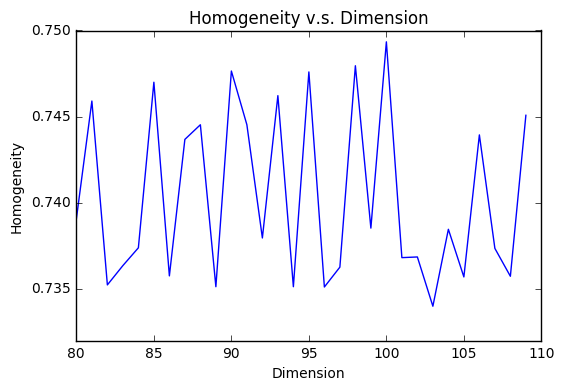

[[ 141 3762]
 [3788  191]]
Homogeneity: 0.748741
Completeness: 0.748696
Adjusted Rand-Index: 0.838591
Adjusted Mutual Information: 0.748673


In [273]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

dimension = range(80,110)
max_score = -1
scores = []
for n_components in dimension:
    lsa = TruncatedSVD(n_components=n_components, n_iter=10, random_state=42)
    ppl = make_pipeline(lsa, Normalizer(copy=False))
    X_lsa = ppl.fit_transform(X_tfidf)

    km.fit(X_lsa)
    predict = km.labels_
    score = metrics.homogeneity_score(y, predict)
    scores.append(score)
    if score>max_score:
        max_score = score
        max_n_components = n_components

print("%d dimensions give the max homogeneity score" % max_n_components)
plt.plot(dimension, scores)
plt.title("Homogeneity v.s. Dimension")
plt.xlabel("Dimension")
plt.ylabel("Homogeneity")
plt.show()

# --------------------------------------------------------------------------
lsa = TruncatedSVD(n_components=max_n_components, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_lsa = ppl.fit_transform(X_tfidf)

km.fit(X_lsa)
predict = km.labels_

# clustering performance evaluations
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

- Applying Logarithm to Reduced Data from LSI

In [275]:
from sklearn.preprocessing import MinMaxScaler

lsa = TruncatedSVD(n_components=max_n_components, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_lsa = ppl.fit_transform(X_tfidf)

min_max_scaler = MinMaxScaler()
X_lsa_minmax = min_max_scaler.fit_transform(X_lsa)
X_lsa_minmax[X_lsa_minmax<1e-10] = 1e-10
X_lsa_log = np.log(X_lsa_minmax)

km.fit(X_lsa_log)
predict = km.labels_

# clustering performance evaluations
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

[[2886 1017]
 [  70 3909]]
Homogeneity: 0.480212
Completeness: 0.503092
Adjusted Rand-Index: 0.524380
Adjusted Mutual Information: 0.480165


[[3812   91]
 [ 785 3194]]
Homogeneity: 0.539203
Completeness: 0.550215
Adjusted Rand-Index: 0.604801
Adjusted Mutual Information: 0.539161


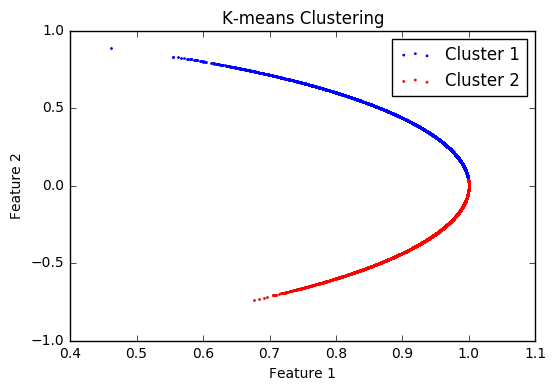

In [276]:
lsa = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_lsa = ppl.fit_transform(X_tfidf)

km.fit(X_lsa)
predict = km.labels_

# clustering performance evaluations
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

color = ['b', 'r']
plt.scatter(X_lsa[predict==1,0], X_lsa[predict==1,1], color='b', s=1, label='Cluster 1')
plt.scatter(X_lsa[predict==0,0], X_lsa[predict==0,1], color='r', s=1, label='Cluster 2')
plt.legend()
plt.title("K-means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

[[ 226 3677]
 [3791  188]]
Homogeneity: 0.703164
Completeness: 0.703306
Adjusted Rand-Index: 0.800911
Adjusted Mutual Information: 0.703137


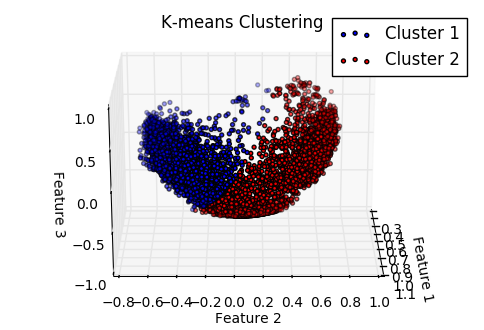

In [277]:
from mpl_toolkits.mplot3d import Axes3D

lsa = TruncatedSVD(n_components=3, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_lsa = ppl.fit_transform(X_tfidf)

km.fit(X_lsa)
predict = km.labels_

# clustering performance evaluations
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color = ['b', 'r']
ax.scatter(X_lsa[predict==1,0], X_lsa[predict==1,1], X_lsa[predict==1,2], c='b', s=8, label='Cluster 1')
ax.scatter(X_lsa[predict==0,0], X_lsa[predict==0,1], X_lsa[predict==0,2], c='r', s=8, label='Cluster 2')
ax.set_title("K-means Clustering")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()
ax.view_init(20, 0)
plt.show()

- Nonnegative Matrix Factorization

18 dimensions give the max homogeneity score


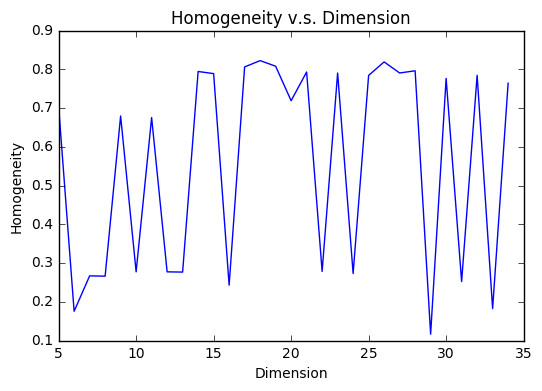

[[3786  117]
 [  94 3885]]
Homogeneity: 0.822237
Completeness: 0.822324
Adjusted Rand-Index: 0.895774
Adjusted Mutual Information: 0.822221


In [278]:
from sklearn.decomposition import NMF

dimension = range(5,35)
max_score = -1
scores = []
for n_components in dimension:
    nmf = NMF(n_components=n_components, max_iter=50, random_state=42)
    ppl = make_pipeline(nmf, Normalizer(copy=False))
    X_nmf = ppl.fit_transform(X_tfidf)

    km.fit(X_nmf)
    predict = km.labels_
    score = metrics.homogeneity_score(y, predict)
    scores.append(score)
    if score>max_score:
        max_score = score
        max_n_components = n_components
        nmf_model = km

print("%d dimensions give the max homogeneity score" % max_n_components)
plt.plot(dimension, scores)
plt.title("Homogeneity v.s. Dimension")
plt.xlabel("Dimension")
plt.ylabel("Homogeneity")
plt.show()

# --------------------------------------------------------------------------
nmf = NMF(n_components=max_n_components, max_iter=50, random_state=42)
ppl = make_pipeline(nmf, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

km.fit(X_nmf)
predict = km.labels_

# clustering performance evaluations
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

- Applying Logarithm to Reduced Data from NMF

In [185]:
nmf = NMF(n_components=max_n_components, max_iter=50, random_state=42)
ppl = make_pipeline(nmf, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

min_max_scaler = MinMaxScaler()
X_nmf_minmax = min_max_scaler.fit_transform(X_nmf)
X_nmf_minmax[X_nmf_minmax<1e-10] = 1e-10
X_nmf_log = np.log(X_nmf_minmax)

km.fit(X_nmf_log)
predict = km.labels_

# clustering performance evaluations
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

[[2162 1741]
 [1965 2014]]
Homogeneity: 0.002612
Completeness: 0.002616
Adjusted Rand-Index: 0.003429
Adjusted Mutual Information: 0.002521


- 2D Plot of Reduced Data

[[3775  128]
 [ 659 3320]]
Homogeneity: 0.558698
Completeness: 0.565056
Adjusted Rand-Index: 0.640442
Adjusted Mutual Information: 0.558657


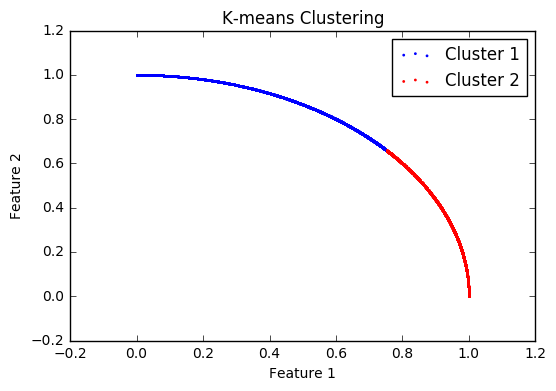

In [255]:
nmf = NMF(n_components=2, max_iter=50, random_state=42)
ppl = make_pipeline(nmf, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

km.fit(X_nmf)
predict = km.labels_

# clustering performance evaluations
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

color = ['b', 'r']
plt.scatter(X_nmf[predict==1,0], X_nmf[predict==1,1], color='b', s=1, label='Cluster 1')
plt.scatter(X_nmf[predict==0,0], X_nmf[predict==0,1], color='r', s=1, label='Cluster 2')
plt.legend()
plt.title("K-means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

- 3D

[[3524  379]
 [  99 3880]]
Homogeneity: 0.682861
Completeness: 0.686040
Adjusted Rand-Index: 0.772104
Adjusted Mutual Information: 0.682832


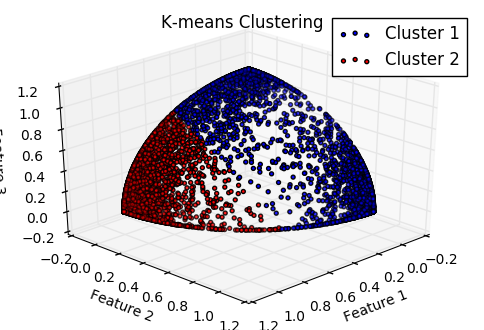

In [260]:
nmf = NMF(n_components=3, max_iter=50, random_state=42)
ppl = make_pipeline(nmf, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

km.fit(X_nmf)
predict = km.labels_

# clustering performance evaluations
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color = ['b', 'r']
ax.scatter(X_nmf[predict==1,0], X_nmf[predict==1,1], X_nmf[predict==1,2], c='b', s=8, label='Cluster 1')
ax.scatter(X_nmf[predict==0,0], X_nmf[predict==0,1], X_nmf[predict==0,2], c='r', s=8, label='Cluster 2')
ax.set_title("K-means Clustering")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()
ax.view_init(30, 45)
plt.show()

## 5) On all 20 sub-class labels 

In [4]:
train_data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

In [26]:
X = np.asarray(train_data.data)
y = train_data.target
y = np.asarray(y)

### transform to TFIDF

In [27]:
# stemming words from the same root
stemmer = PorterStemmer()

# vectorize documents
vectorizer = CountVectorizer(min_df=1, stop_words='english', tokenizer=tokenize_and_stem)
X_vect = vectorizer.fit_transform(X)
print(X_vect.shape)

# transform into TFIDF
tfidf_transformer = TfidfTransformer(sublinear_tf=True, use_idf=True)
X_tfidf = tfidf_transformer.fit_transform(X_vect)
print(X_tfidf.shape)

(18846, 99045)
(18846, 99045)


### Dimension reduction - NMF

20
--- 0.00422096252441 seconds ---
30
--- 326.904736996 seconds ---
40
--- 797.618060827 seconds ---
50
--- 1472.65142083 seconds ---
60
--- 2485.12671995 seconds ---
70
--- 3516.71753693 seconds ---
80
--- 4605.62611079 seconds ---
90
--- 6067.44095397 seconds ---
100
--- 7849.63812399 seconds ---
33 dimensions give the max homogeneity score


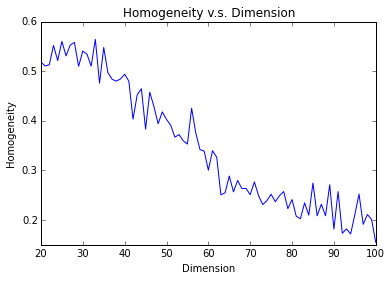

Homogeneity: 0.572720
Completeness: 0.589891
Adjusted Rand-Index: 0.399455
Adjusted Mutual Information: 0.571340


In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import time

start = time.time()
# dimension = range(5,35)
dimension = range(20,101)
max_score = -1
scores = []
km = KMeans(n_clusters=20)
for n_components in dimension:
    if n_components % 10 == 0:
        print n_components
        print("--- %s seconds ---" % (time.time() - start))
    nmf = NMF(n_components=n_components, max_iter=50, random_state=42)
    ppl = make_pipeline(nmf, Normalizer(copy=False))
    X_nmf = ppl.fit_transform(X_tfidf)

    km.fit(X_nmf)
    predict = km.labels_
    score = metrics.homogeneity_score(y, predict)
    scores.append(score)
    if score>max_score:
        max_score = score
        max_n_components = n_components
        nmf_model = km

print("%d dimensions give the max homogeneity score" % max_n_components)
plt.plot(dimension, scores)
plt.title("Homogeneity v.s. Dimension")
plt.xlabel("Dimension")
plt.ylabel("Homogeneity")
plt.show()

# --------------------------------------------------------------------------
nmf = NMF(n_components=max_n_components, max_iter=50, random_state=42)
ppl = make_pipeline(nmf, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

km.fit(X_nmf)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

In [49]:
# print(metrics.confusion_matrix(y, predict))

#### Applying Logarithm to Reduced Data from NMF

In [57]:
from sklearn.preprocessing import MinMaxScaler
km = KMeans(n_clusters=20)

nmf = NMF(n_components=33, max_iter=50, random_state=42)
ppl = make_pipeline(nmf, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

min_max_scaler = MinMaxScaler()
X_nmf_minmax = min_max_scaler.fit_transform(X_nmf)
X_nmf_minmax[X_nmf_minmax<1e-10] = 1e-10
X_nmf_log = np.log(X_nmf_minmax)

km.fit(X_nmf_log)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

Homogeneity: 0.133007
Completeness: 0.133053
Adjusted Rand-Index: 0.054418
Adjusted Mutual Information: 0.130210


#### Applying Square to Reduced Data from NMF

In [58]:
km = KMeans(n_clusters=20)

nmf = NMF(n_components=33, max_iter=50, random_state=42)
ppl = make_pipeline(nmf, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

min_max_scaler = MinMaxScaler()
X_nmf_minmax = min_max_scaler.fit_transform(X_nmf)
X_nmf_minmax[X_nmf_minmax<1e-10] = 1e-10
X_nmf_square = np.square(X_nmf_minmax)

km.fit(X_nmf_square)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

Homogeneity: 0.491192
Completeness: 0.521238
Adjusted Rand-Index: 0.263015
Adjusted Mutual Information: 0.489549


### Dimension reduction - SVD

In [ ]:
start = time.time()
# dimension = range(5,35)
dimension = range(80,110)
max_score = -1
scores = []
for n_components in dimension:
    if n_components % 10 == 0:
        print n_components
        print("--- %s seconds ---" % (time.time() - start))
    lsa = TruncatedSVD(n_components=n_components, n_iter=10, random_state=42)
    ppl = make_pipeline(lsa, Normalizer(copy=False))
    X_lsa = ppl.fit_transform(X_tfidf)

    km.fit(X_lsa)
    predict = km.labels_
    score = metrics.homogeneity_score(y, predict)
    scores.append(score)
    if score>max_score:
        max_score = score
        max_n_components = n_components

print("%d dimensions give the max homogeneity score" % max_n_components)
plt.plot(dimension, scores)
plt.title("Homogeneity v.s. Dimension")
plt.xlabel("Dimension")
plt.ylabel("Homogeneity")
plt.show()

# --------------------------------------------------------------------------
lsa = TruncatedSVD(n_components=max_n_components, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_lsa = ppl.fit_transform(X_tfidf)

km.fit(X_lsa)
predict = km.labels_

# clustering performance evaluations
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

[[  1 377   0   9   0 250   0   0   1   3   2   0   0  99   0   0   0   3
    7  47]
 [  0   0  79   2   0   2  34  70   6 282  62   0   0 177   0   1   2   1
  250   5]
 [  1   1 134   0   0   0  13 386   2 199  19   0   0  91   0  32   1   4
   95   7]
 [  1   0 217   0   0   0  66  36  13  22  86   0   0 103   0 274   4   0
  158   2]
 [  0   0  40   0   0   0 551   9  15  11  51   0   0  81   0 105   0   0
   98   2]
 [  0   0   7   0   0   0   2 648   1  95   6   0   0  90   0   0   0   0
  137   2]
 [  1   0  29   0   0   0  18   1 625   8  27   2   0  88   2  74  20   2
   74   4]
 [  1   0   0   1   0   0   0   4  18   2  31   8   0 128   0   3 699   0
   61  34]
 [  0   0   0   4   1   0   1   1  17   0  19 801   0  80   1   5  25   1
   20  20]
 [  0   0   0   0 747   1   0   0   3   4   3   1   0 130  39   1   0   0
   56   9]
 [  0   0   0   0   8   3   1   0   1   0   0   0   0 100 861   0   1   0
   20   4]
 [738   1   1   2   0   0   2   9   0  19  37   0   0  73   0   2   0   0
   30  77]
 [ 11   0  16   0   0   0  29  11  14  20 525   0   0 145   1  19  17   6
  168   2]
 [  0   1   0 692   1  11   0   3   2   2  20   2   0 132   0   0   1   5
  112   6]
 [  0   0   0   5   1   2   0   2   1   9  17   0   0 104   1   3   1 790
   37  14]
 [  1  13   0   8   0 821   0   0   0   2   0   0   2  98   0   0   0   0
   34  18]
 [  8   2   2   2   0   3   0   0   7   0   1   0   1  91   0   0   3   0
   12 778]
 [  0 284   0   2   1   6   1   0   0   1   1   0 468 101   0   0   2   0
    4  69]
 [  2   1   0 172   3  12   0   0   4   0   1   1   2 145   0   0   2   5
    6 419]
 [  0 105   0  12   1 296   0   0   0   2   0   1   1 111   0   0   1   2
    8  88]]

Homogeneity: 0.580998
Completeness: 0.596173
Adjusted Rand-Index: 0.402390
Adjusted Mutual Information: 0.579645

In [61]:
from sklearn.decomposition import TruncatedSVD
km = KMeans(n_clusters=20)

lsa = TruncatedSVD(n_components=106, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_lsa = ppl.fit_transform(X_tfidf)

km.fit(X_lsa)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

Homogeneity: 0.570994
Completeness: 0.589098
Adjusted Rand-Index: 0.384131
Adjusted Mutual Information: 0.569608


In [63]:
from sklearn.decomposition import TruncatedSVD
km = KMeans(n_clusters=20)

lsa = TruncatedSVD(n_components=146, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_lsa = ppl.fit_transform(X_tfidf)

km.fit(X_lsa)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

Homogeneity: 0.571052
Completeness: 0.592505
Adjusted Rand-Index: 0.377079
Adjusted Mutual Information: 0.569667


[[148  88   2   3   0  45   1   0   5   0   1   0   4   0   1   0   3   0
  496   2]
 [  0 170   1   0 111  12   5  61 258   0   0   0   0  73   2   0 279   0
    0   1]
 [  0  83   0   0  54   9   3 377  99   0   1   0   0 120   1  34 199   0
    2   3]
 [  0  64   0   0 236   0  14  27 138   0   1   0   0 209   3 269  19   0
    2   0]
 [  0  91   0   0 509   4  16   6 124   0   0   0   0  67   0 133  12   0
    0   1]
 [  0  88   0   0  21   3   1 632 144   0   0   0   0   7   0   0  92   0
    0   0]
 [  0  99   0   0  44   9 616   2  71   0   1   2   0  29  19  73   6   2
    0   2]
 [  0 143   0   0  17  35  18   4  65   0   1   8   1   0 692   3   2   0
    0   1]
 [  0  93   1   0  15  30  16   1  20   1   0 787   0   0  25   5   0   1
    0   1]
 [  0 148   0   0   0  12   3   0  53 741   0   1   0   0   0   0   4  31
    1   0]
 [  2 101   0   0   1   7   1   0  22   8   0   0   0   0   1   0   1 855
    0   0]
 [  0  79   0   0  52 101   0   7  25   0 705   0   0   0   0   2  20   0
    0   0]
 [  0 164   0   0 538   5  14   7 166   0   5   0   0  17  22  19  16   1
    0  10]
 [  1 224 584   0  17  17   3   1 109   2   0   2   3   0   1   0   2   0
   18   6]
 [  1 116   3   0  10  24   1   1  37   1   0   0   1   0   1   3   9   1
    0 778]
 [774 110   4   4   0  25   0   0  35   0   1   0   3   0   0   0   2   0
   39   0]
 [  3  84   0   1   2 409   7   0   9   0   6   0 385   2   2   0   0   0
    0   0]
 [  6 127   0 700   0  91   0   0   5   1   0   0   1   0   2   0   0   0
    7   0]
 [  7 121   4   2   0 357   4   0   7   2   2   0 103   0   1   0   0   0
  159   6]
 [244 134   2   3   1  36   0   0   7   0   0   1  70   0   1   0   2   0
  125   2]]
  
Homogeneity: 0.570917
Completeness: 0.587209
Adjusted Rand-Index: 0.376445
Adjusted Mutual Information: 0.569532

#### SVD - Logarithm 

In [64]:
from sklearn.preprocessing import MinMaxScaler
km = KMeans(n_clusters=20)

lsa = TruncatedSVD(n_components=146, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

min_max_scaler = MinMaxScaler()
X_nmf_minmax = min_max_scaler.fit_transform(X_nmf)
X_nmf_minmax[X_nmf_minmax<1e-10] = 1e-10
X_nmf_log = np.log(X_nmf_minmax)

km.fit(X_nmf_log)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

Homogeneity: 0.469533
Completeness: 0.509188
Adjusted Rand-Index: 0.249504
Adjusted Mutual Information: 0.467817


#### SVD - squared

In [65]:
km = KMeans(n_clusters=20)

lsa = TruncatedSVD(n_components=146, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

min_max_scaler = MinMaxScaler()
X_nmf_minmax = min_max_scaler.fit_transform(X_nmf)
X_nmf_minmax[X_nmf_minmax<1e-10] = 1e-10
X_nmf_square = np.square(X_nmf_minmax)

km.fit(X_nmf_square)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

Homogeneity: 0.470968
Completeness: 0.530224
Adjusted Rand-Index: 0.251125
Adjusted Mutual Information: 0.469253


## 6) Topic-wise classes

In [79]:
train_data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [106]:
def map_label(d):
    if d == 0 or d == 15 or d == 19:
        return 5
    elif d >= 1 and d <= 5:
        return 0
    elif d == 6:
        return 3
    elif d >= 7 and d <= 10:
        return 1
    elif d >= 11 and d <= 14:
        return 2
    elif d >= 16 and d <= 18:
        return 4

In [107]:
fun = np.vectorize(map_label)

X = np.asarray(train_data.data)
y = fun(train_data.target)
y = np.asarray(y)

### NMF

In [109]:
km = KMeans(n_clusters=6)
nmf = NMF(n_components=5, max_iter=50, random_state=42)
ppl = make_pipeline(nmf, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

km.fit(X_nmf)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

Homogeneity: 0.462728
Completeness: 0.479688
Adjusted Rand-Index: 0.417113
Adjusted Mutual Information: 0.462517


--- 36.7529678345 seconds ---
10
Current best dimension choice:  6
Current best score:  0.488139823169
--- 185.562645912 seconds ---
20
Current best dimension choice:  15
Current best score:  0.514990866471
--- 392.259080887 seconds ---
30
Current best dimension choice:  15
Current best score:  0.514990866471
--- 713.628680944 seconds ---
40
Current best dimension choice:  15
Current best score:  0.514990866471
15 dimensions give the max homogeneity score


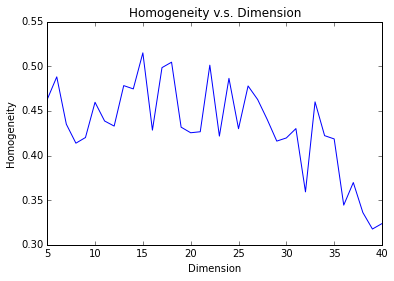

Homogeneity: 0.486641
Completeness: 0.493026
Adjusted Rand-Index: 0.346387
Adjusted Mutual Information: 0.486440


In [117]:
start = time.time()
# dimension = range(5,35)
dimension = range(5,41)
max_score = -1
scores = []
km = KMeans(n_clusters=6)
for n_components in dimension:
    if n_components % 10 == 0:
        print("--- %s seconds ---" % (time.time() - start))
        print n_components
        print "Current best dimension choice: ",max_n_components
        print "Current best score: ",max_score
        
    nmf = NMF(n_components=n_components, max_iter=50, random_state=42)
    ppl = make_pipeline(nmf, Normalizer(copy=False))
    X_nmf = ppl.fit_transform(X_tfidf)

    km.fit(X_nmf)
    predict = km.labels_
    score = metrics.homogeneity_score(y, predict)
    scores.append(score)
    if score>max_score:
        max_score = score
        max_n_components = n_components
        nmf_model = km

print("%d dimensions give the max homogeneity score" % max_n_components)
plt.plot(dimension, scores)
plt.title("Homogeneity v.s. Dimension")
plt.xlabel("Dimension")
plt.ylabel("Homogeneity")
plt.show()

# --------------------------------------------------------------------------
nmf = NMF(n_components=max_n_components, max_iter=50, random_state=42)
ppl = make_pipeline(nmf, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

km.fit(X_nmf)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

#### logarithm

In [118]:
km = KMeans(n_clusters=6)

nmf = NMF(n_components=max_n_components, max_iter=50, random_state=42)
ppl = make_pipeline(nmf, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

min_max_scaler = MinMaxScaler()
X_nmf_minmax = min_max_scaler.fit_transform(X_nmf)
X_nmf_minmax[X_nmf_minmax<1e-10] = 1e-10
X_nmf_log = np.log(X_nmf_minmax)

km.fit(X_nmf_log)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

Homogeneity: 0.085640
Completeness: 0.081593
Adjusted Rand-Index: 0.064678
Adjusted Mutual Information: 0.081251


In [119]:
km = KMeans(n_clusters=6)

nmf = NMF(n_components=max_n_components, max_iter=50, random_state=42)
ppl = make_pipeline(nmf, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

min_max_scaler = MinMaxScaler()
X_nmf_minmax = min_max_scaler.fit_transform(X_nmf)
X_nmf_minmax[X_nmf_minmax<1e-10] = 1e-10
X_nmf_square = np.square(X_nmf_minmax)

km.fit(X_nmf_square)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

Homogeneity: 0.410308
Completeness: 0.441799
Adjusted Rand-Index: 0.254731
Adjusted Mutual Information: 0.410077


### svd

--- 0.000606060028076 seconds ---
80
Current best dimension choice:  15
Current best score:  -1
--- 179.086412907 seconds ---
90
Current best dimension choice:  81
Current best score:  0.502351746633
--- 384.884795904 seconds ---
100
Current best dimension choice:  81
Current best score:  0.502351746633
--- 608.696005106 seconds ---
110
Current best dimension choice:  81
Current best score:  0.502351746633
--- 849.103732109 seconds ---
120
Current best dimension choice:  81
Current best score:  0.502351746633
81 dimensions give the max homogeneity score


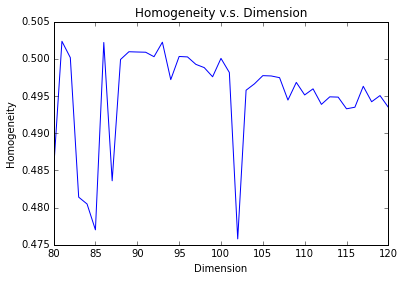

Homogeneity: 0.502393
Completeness: 0.517003
Adjusted Rand-Index: 0.346484
Adjusted Mutual Information: 0.502198


In [120]:
start = time.time()
dimension = range(80,121)
max_score = -1
scores = []
km = KMeans(n_clusters=6)
for n_components in dimension:
    if n_components % 10 == 0:
        print("--- %s seconds ---" % (time.time() - start))
        print n_components
        print "Current best dimension choice: ",max_n_components
        print "Current best score: ",max_score
    lsa = TruncatedSVD(n_components=n_components, n_iter=10, random_state=42)
    ppl = make_pipeline(lsa, Normalizer(copy=False))
    X_lsa = ppl.fit_transform(X_tfidf)

    km.fit(X_lsa)
    predict = km.labels_
    score = metrics.homogeneity_score(y, predict)
    scores.append(score)
    if score>max_score:
        max_score = score
        max_n_components = n_components

print("%d dimensions give the max homogeneity score" % max_n_components)
plt.plot(dimension, scores)
plt.title("Homogeneity v.s. Dimension")
plt.xlabel("Dimension")
plt.ylabel("Homogeneity")
plt.show()

# --------------------------------------------------------------------------
lsa = TruncatedSVD(n_components=max_n_components, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_lsa = ppl.fit_transform(X_tfidf)

km.fit(X_lsa)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

#### logarithm

In [121]:
km = KMeans(n_clusters=6)

lsa = TruncatedSVD(n_components=max_n_components, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

min_max_scaler = MinMaxScaler()
X_nmf_minmax = min_max_scaler.fit_transform(X_nmf)
X_nmf_minmax[X_nmf_minmax<1e-10] = 1e-10
X_nmf_log = np.log(X_nmf_minmax)

km.fit(X_nmf_log)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

Homogeneity: 0.275315
Completeness: 0.312030
Adjusted Rand-Index: 0.132519
Adjusted Mutual Information: 0.275031


#### squared

In [122]:
km = KMeans(n_clusters=6)

lsa = TruncatedSVD(n_components=max_n_components, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

min_max_scaler = MinMaxScaler()
X_nmf_minmax = min_max_scaler.fit_transform(X_nmf)
X_nmf_minmax[X_nmf_minmax<1e-10] = 1e-10
X_nmf_square = np.square(X_nmf_minmax)

km.fit(X_nmf_square)
predict = km.labels_

# clustering performance evaluations
# print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

Homogeneity: 0.313822
Completeness: 0.333878
Adjusted Rand-Index: 0.177972
Adjusted Mutual Information: 0.313553
